In [1]:
# =========================================
# 1) Setup & Import
# =========================================
import os, random, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from PIL import Image
import tkinter as tk
from tkinter import filedialog

# Konfigurasi GPU (limit 7.8 GB)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth before configuring logical/virtual devices.
        # Setting memory growth after virtual devices are configured raises:
        # ValueError: Cannot set memory growth on device when virtual devices configured
        tf.config.set_logical_device_configuration(
            tf.config.list_physical_devices("GPU")[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=7800)],
        )

        print(f"✅ GPU terdeteksi: {gpus[0].name} (VRAM limit: 7800MB)")
    except RuntimeError as e:
        print("GPU config error:", e)
else:
    print("⚠️ GPU tidak terdeteksi. Training akan dilakukan di CPU.")

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


✅ GPU terdeteksi: /physical_device:GPU:0 (VRAM limit: 7800MB)


In [2]:
# =========================================
# 2) Konfigurasi Dataset & Param
# =========================================
DATASET_DIR = r"Rice_Leaf_AUG/Rice_Leaf_AUG"   # ganti jika beda
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
TARGET_PER_CLASS = 1000     # diratakan jadi 1000 per label
VAL_RATIO = 0.05
TEST_RATIO = 0.05
TRAIN_RATIO = 0.90
assert abs((TRAIN_RATIO+VAL_RATIO+TEST_RATIO) - 1.0) < 1e-6

# Ekstensi gambar yang diterima
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

In [3]:
# =========================================
# 3) Enumerasi Kelas & Kumpulkan Filepath
# =========================================
class_names = sorted([d for d in os.listdir(DATASET_DIR) 
                      if os.path.isdir(os.path.join(DATASET_DIR, d))])
print("Classes:", class_names)

def list_images_in_dir(d):
    files = []
    for ext in IMG_EXTS:
        files.extend(glob.glob(os.path.join(d, f"*{ext}")))
    return files

per_class_files = {}
for cname in class_names:
    folder = os.path.join(DATASET_DIR, cname)
    files = list_images_in_dir(folder)
    files = [f for f in files if os.path.isfile(f)]
    if len(files) == 0:
        raise ValueError(f"Tidak ada gambar pada kelas: {cname}")
    per_class_files[cname] = files
    print(f"{cname}: {len(files)} file")

Classes: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Rice Hispa', 'Sheath Blight']
Bacterial Leaf Blight: 1197 file
Brown Spot: 1546 file
Healthy Rice Leaf: 1085 file
Leaf Blast: 1748 file
Leaf scald: 1332 file
Narrow Brown Leaf Spot: 954 file
Rice Hispa: 1299 file
Sheath Blight: 1629 file


In [4]:
# =========================================
# 4) Ratakan jumlah data per kelas = 1000
#    - Jika > 1000 -> random DOWN-sample 1000
#    - Jika < 1000 -> random OVER-sample (sampling dengan pengulangan)
# =========================================
balanced_files = {}
for cname, files in per_class_files.items():
    n = len(files)
    if n >= TARGET_PER_CLASS:
        balanced = random.sample(files, TARGET_PER_CLASS)
    else:
        # oversample dengan replacement
        balanced = random.choices(files, k=TARGET_PER_CLASS)
    balanced_files[cname] = balanced
    print(f"[Balanced] {cname}: {len(balanced)}")

[Balanced] Bacterial Leaf Blight: 1000
[Balanced] Brown Spot: 1000
[Balanced] Healthy Rice Leaf: 1000
[Balanced] Leaf Blast: 1000
[Balanced] Leaf scald: 1000
[Balanced] Narrow Brown Leaf Spot: 1000
[Balanced] Rice Hispa: 1000
[Balanced] Sheath Blight: 1000


In [ ]:
# =========================================
# 5) Split Stratified 90/5/5 per Kelas
# =========================================
train_files, val_files, test_files = [], [], []
train_labels, val_labels, test_labels = [], [], []

for label_idx, cname in enumerate(class_names):
    files = balanced_files[cname]   
    random.shuffle(files)

    n_total = len(files)
    n_val = int(round(n_total * VAL_RATIO))
    n_test = int(round(n_total * TEST_RATIO))
    n_train = n_total - n_val - n_test

    train = files[:n_train]
    val   = files[n_train:n_train+n_val]
    test  = files[n_train+n_val:n_train+n_val+n_test]

    train_files.extend(train); train_labels.extend([label_idx]*len(train))
    val_files.extend(val);     val_labels.extend([label_idx]*len(val))
    test_files.extend(test);   test_labels.extend([label_idx]*len(test))

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 7200, Val: 400, Test: 400


In [6]:
# =========================================
# 6) tf.data Pipeline (augment di train)
# =========================================
AUTOTUNE = tf.data.AUTOTUNE
# Tidak melakukan augmentasi karena dataset sudah di-augment sebelumnya

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)   # ResNetV2 preproc
    return img, tf.cast(label, tf.int32)

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: load_image(p, y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_files, train_labels, training=True)
val_ds   = make_ds(val_files, val_labels, training=False)
test_ds  = make_ds(test_files, test_labels, training=False)


In [7]:
# =========================================
# 7) Bangun Model: ResNet50V2 + Dense Head
# =========================================
inputs = layers.Input(shape=(*IMG_SIZE, 3))
base = ResNet50V2(include_top=False, weights="imagenet", input_tensor=inputs)
base.trainable = False  # freeze awal (bisa di-unfreeze untuk fine-tune)

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs, name="ResNet50V2_rice_leaf")
model.summary()

Model: "ResNet50V2_rice_leaf"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                               

In [ ]:
# =========================================
# 8) Train
# =========================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_resnet50v2.keras", monitor="val_accuracy",
                                       save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=9,
                                     restore_best_weights=True, mode="max", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3,
                                         min_lr=1e-7, verbose=1, mode="min")
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)



Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.5448 - accuracy: 0.4900
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to best_resnet50v2.keras
113/113 [==============================] - 19s 127ms/step - loss: 1.5448 - accuracy: 0.4900 - val_loss: 1.1536 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.2418 - accuracy: 0.5665
Epoch 2: val_accuracy improved from 0.57500 to 0.62000, saving model to best_resnet50v2.keras
113/113 [==============================] - 13s 118ms/step - loss: 1.2418 - accuracy: 0.5665 - val_loss: 1.1062 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 1.1470 - accuracy: 0.6064
Epoch 3: val_accuracy improved from 0.62000 to 0.73000, saving model to best_resnet50v2.keras
113/113 [==============================] - 13s 117ms/step - loss: 1.1470 - accuracy: 0.6064 - val_loss: 0.8076 - val_accuracy: 0.7300 - 

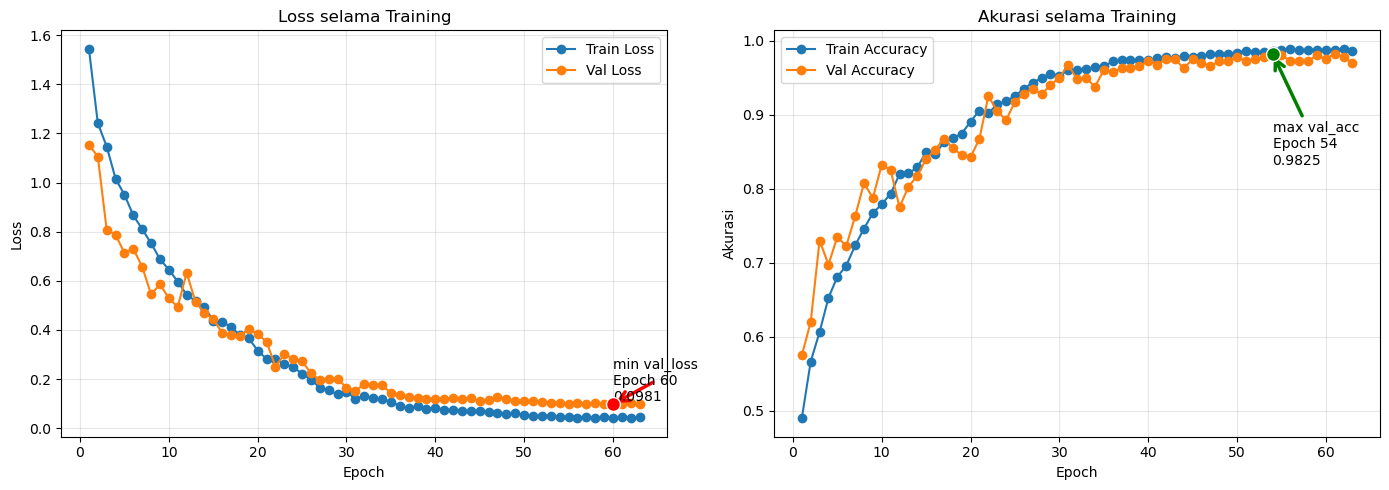

In [9]:
# =========================================
# 9) Train Evaluation loss & accuracy Plot
# =========================================
if "history" not in globals():
    print("Variabel 'history' tidak ditemukan.")
else:
    h = history.history
    epochs = range(1, len(h.get("loss", [])) + 1)

    def plot_series(ax, x, y, label, **kwargs):
        ax.plot(x, y, label=label, **kwargs)
        ax.grid(alpha=0.3)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].set_title("Loss selama Training")
    plot_series(axes[0], epochs, h.get("loss", []), "Train Loss", marker="o", markersize=6)
    if "val_loss" in h:
        plot_series(axes[0], epochs, h["val_loss"], "Val Loss", marker="o", markersize=6)
        # tandai epoch terbaik (min val_loss)
        best_idx = int(np.argmin(h["val_loss"])) + 1
        best_val = np.min(h["val_loss"])
        # marker besar di titik terbaik
        axes[0].scatter(best_idx, best_val, s=100, c="red", edgecolors="white", zorder=5)
        axes[0].annotate(
            f"min val_loss\nEpoch {best_idx}\n{best_val:.4f}",
            xy=(best_idx, best_val), xytext=(best_idx, best_val * 1.12),
            arrowprops=dict(arrowstyle="->", color="red", linewidth=2.5, mutation_scale=18),
            fontsize=10
        )
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy
    axes[1].set_title("Akurasi selama Training")
    if "accuracy" in h:
        plot_series(axes[1], epochs, h["accuracy"], "Train Accuracy", marker="o", markersize=6)
    if "val_accuracy" in h:
        plot_series(axes[1], epochs, h["val_accuracy"], "Val Accuracy", marker="o", markersize=6)
        # tandai epoch terbaik (max val_accuracy)
        best_idx = int(np.argmax(h["val_accuracy"])) + 1
        best_val = np.max(h["val_accuracy"])
        # marker besar di titik terbaik
        axes[1].scatter(best_idx, best_val, s=100, c="green", edgecolors="white", zorder=5)
        axes[1].annotate(
            f"max val_acc\nEpoch {best_idx}\n{best_val:.4f}",
            xy=(best_idx, best_val),
            xytext=(best_idx, max(0.1, best_val - 0.15)),
            arrowprops=dict(arrowstyle="->", color="green", linewidth=2.5, mutation_scale=18),
            fontsize=10
        )
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Akurasi")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("training_history.png", dpi=150)
    plt.show()

7/7 [==============================] - 2s 194ms/step

Classification Report:
                        precision    recall  f1-score   support

 Bacterial Leaf Blight     0.8545    0.9400    0.8952        50
            Brown Spot     1.0000    0.9600    0.9796        50
     Healthy Rice Leaf     0.9796    0.9600    0.9697        50
            Leaf Blast     0.9000    0.9000    0.9000        50
            Leaf scald     0.9592    0.9400    0.9495        50
Narrow Brown Leaf Spot     0.9583    0.9200    0.9388        50
            Rice Hispa     0.9423    0.9800    0.9608        50
         Sheath Blight     0.9592    0.9400    0.9495        50

              accuracy                         0.9425       400
             macro avg     0.9441    0.9425    0.9429       400
          weighted avg     0.9441    0.9425    0.9429       400



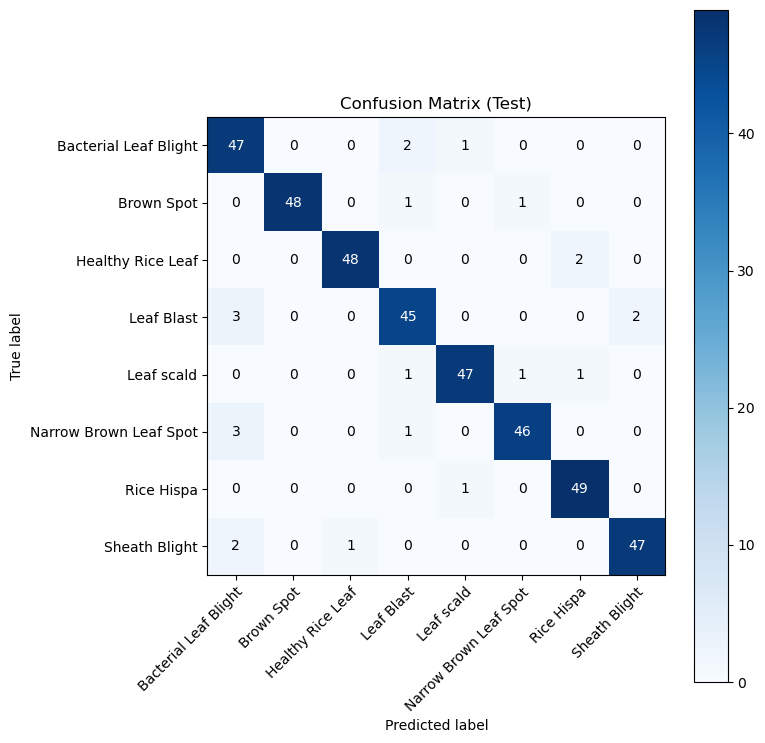

In [ ]:
# =========================================
# 10) Evaluasi: Confusion Matrix & Report
# =========================================
# Prediksi pada test set
y_true = np.array(test_labels)
y_prob = model.predict(test_ds, verbose=1)
y_pred = y_prob.argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix (warna: putih -> biru)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names, yticklabels=class_names,
    ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (Test)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_facecolor("white")

# Tampilkan angka di kotak (teks putih pada sel gelap)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

In [11]:
# =========================================
# 11) Save Model
# =========================================
model.save("model/best_resnet50v2.keras")

In [12]:
# =========================================
# 12) Save Model (.keras dan .onnx)
# =========================================
import onnx
import tf2onnx

# Pastikan ada objek `model` di memori; kalau tidak, coba muat dari disk
if "model" not in globals():
	try:
		model = tf.keras.models.load_model("model/best_resnet50v2.keras", compile=False)
		print("✅ Model dimuat dari 'model/best_resnet50v2.keras'")
	except Exception as e:
		raise NameError(
			"Model tidak ditemukan di memori dan gagal dimuat dari 'model/best_resnet50v2.keras'. "
			"Jalankan training atau simpan model terlebih dahulu."
		) from e

# Konversi ke format ONNX
onnx_path = "model/best_resnet50v2.onnx"
os.makedirs(os.path.dirname(onnx_path), exist_ok=True)

# Gunakan tf2onnx untuk export
spec = (tf.TensorSpec((None, *IMG_SIZE, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save(onnx_model, onnx_path)
print(f"✅ Model juga disimpan sebagai file: {onnx_path}")


✅ Model juga disimpan sebagai file: model/best_resnet50v2.onnx


Prediksi: Leaf Blast | Confidence: 0.9994


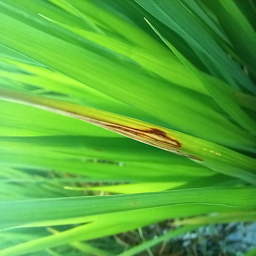

In [ ]:
# =========================================
# 13) Inference Helper
# =========================================

# Muat model terbaik kalau belum
try:
    model = tf.keras.models.load_model("model/best_resnet50v2.onnx", compile=False)
except Exception:
    pass  # pakai 'model' di memori kalau ada

def predict_image(img_path):
    # Load + preprocess
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    img = tf.expand_dims(img, 0)  # batch dim
    prob = model.predict(img, verbose=0)[0]
    idx = int(np.argmax(prob))
    return class_names[idx], float(prob[idx]), prob

# --- Opsi A: dialog pilih file ---
def choose_and_predict():
    root = tk.Tk(); root.withdraw()
    fpath = filedialog.askopenfilename(title="Pilih gambar daun padi",
                                       filetypes=[("Images", "*.jpg;*.jpeg;*.png;*.bmp;*.gif")])
    if not fpath:
        print("Tidak ada file dipilih.")
        return
    label, conf, prob = predict_image(fpath)
    print(f"Prediksi: {label} | Confidence: {conf:.4f}")
    display(Image.open(fpath).resize((256, 256)))

choose_and_predict()

# --- Opsi B: path manual ---
# path_manual = r"C:\path\to\sample.jpg"
# label, conf, _ = predict_image(path_manual)
# print(f"Prediksi: {label} | Confidence: {conf:.4f}")
